In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary
from pysindy.differentiation import FiniteDifference
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
from pysindy.feature_library import CustomLibrary
import math
import pysindy.feature_library
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import pchip_interpolate

In [1]:
!pip install pysindy # I needed this to use colab. You do not need to run this

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip install --force-reinstall numpy==1.23.5 #needed for colab. You do not need to run

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 33.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
bigframes 2.4.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is inco

In [10]:
def logistic_growth_controlled(y, t, params, treatment_function, cycles):
    """
    Differential equation for logistic growth with a control term for Leukemic stem cells in active

    Args:
        y (float): Current population size.
        t (float): Current time.
        params (array float): array with parameter values.
        treatment_function : A function that takes time and cycles (t, cycle) and returns  u in {0,1}  ( 0 means no treatment and 1 treatment).
        cycles : treatment cycles

    Returns:
        float: The rate of change of the population size (dy/dt).
    """
    control = treatment_function(t,cycles)
    p_l, K_A, d_k, c = params
    dydt = ( p_l * (1 - y / K_A) - c*control -d_k ) * y
    return dydt

In [4]:
from google.colab import drive #this was for colab as well
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
## This is how we read the treatment data for a patient
def treatment_cycle( patient_id ) :

    #patient_id = 104
    # read all data.  [[ Boris ]] Its inefficient to read all data here; but we can optimize this later
    chemo_data = pd.read_csv('gdrive/My Drive/rsif20200091_si_003.csv')
    # get treatment information from a specific patient
    chemo_row = chemo_data[chemo_data.PatientID==patient_id].iloc[0]

    chemo_start_times = [int(x) for x in chemo_row['Chemo_begin'].split()] # starting times of therapy cycle
    chemo_end_times = [int(x) for x in chemo_row['Chemo_end'].split()] #

    return   [ chemo_start_times , chemo_end_times ]    ## [[ Boris ]] we may need a better data structure here


In [12]:
# Define a control function (example: constant control after a certain time)
def treatment_function(time, cycles ):

    chemo_start_times, chemo_end_times  = cycles

    Ncycles = len(chemo_start_times)

    for i in range(Ncycles) :
        if chemo_start_times[i] <= time <= chemo_end_times[i]  :
            return 1.0  # Apply 60% control

    return 0.0  # No control


In [ ]:

#def treatment_interpolation_function(time, cycles):
  #treatment_function_values=np.array([treatment_function(time,cycles) for time in t])
  #
  #return pchip_interpolate(t, treatment_function_values, time)



## Run a Simulation

In [187]:
# Setting parameters for simulations
p_l = 0.11337807
K_A = 10000
d_k = 1/30
c = 1.2114013

# Initial value
La_o = 10000*.10

t = np.linspace(0, 500, 2000) # Time points

discont=np.array([0,6,19,25,62,66,116,120,168,172]) #points where treatment turns on and off
# epsilon=1
# for point in discont:
#   t = t[(t < point-epsilon) | (t > point+epsilon)] #remove a small range of time points around the discontinuity

# print(t)



#print(t.shape)

In [188]:
## Generate a trajectory with patient control

# determine treatment cycles
## This is how we read the treatment data for a patient
patient_id = 104
cycles = treatment_cycle( patient_id )

# names of the parameters to fit
params = [p_l, K_A, d_k, c]

results = odeint(logistic_growth_controlled, La_o , t, args=(params, treatment_function, cycles))
results_prime_true=np.array([logistic_growth_controlled(y,time,params,treatment_function,cycles) for y,time in zip(results,t)])
print(results_prime_true.shape)
print(results)
print(results.shape[0])





(2000, 1)
[[1000.        ]
 [ 751.67778292]
 [ 565.36541109]
 ...
 [7059.06278557]
 [7059.08104479]
 [7059.0989422 ]]
2000


In [189]:
# treatment_function_values=np.array([treatment_function(time,cycles,0.1) for time in t])
# print(treatment_function_values.shape)
# values_smooth = gaussian_filter1d(treatment_function_values, sigma=3)
#print(treatment_function_values)
#print(values_smooth)
#plot the true derivative vs the PySindy derivative
# fig, ax = plt.subplots()
# chemo_start_times, chemo_end_times = cycles
# plt.plot(t[0:300], treatment_function_values[0:300], label='treament_function')
# plt.plot(t[0:300], values_smooth[0:300], label='treatment_function_smooth')
# plt.yscale('linear')

# for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
#     label = None
#     # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
#     if i == 0:
#         label = 'chemo'
#     plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
#                         label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
# plt.axhline(y = 1, color = 'r', linestyle = '--')
# plt.title(f'Patient {patient_id}')
# plt.xlabel('time (days)')
# plt.ylabel('Cell count')
# plt.legend()
# plt.show()
#MSE_der = np.square(np.subtract(results_prime_true[:,0],results_prime[:,0])).mean()
#print("The MSE of the derivatives is", MSE_der)

In [190]:
fd=FiniteDifference()
results_prime=fd._differentiate(results,t) #derivative does not include c, X'
print("The size of X' is ", results_prime.shape)

The size of X' is  (2000, 1)


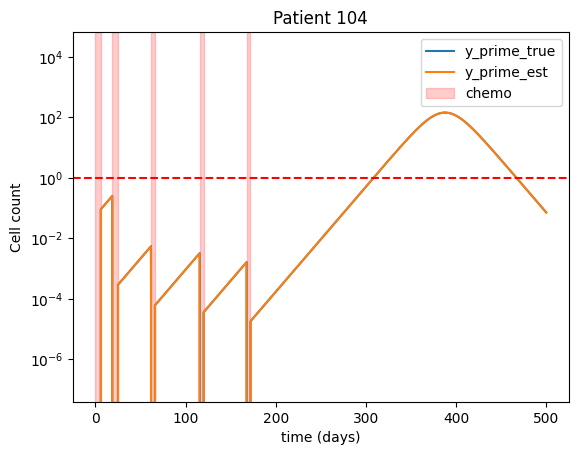

The MSE of the derivatives is 0.5011422452714425


In [191]:
#plot the true derivative vs the PySindy derivative
fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results_prime_true, label='y_prime_true')
plt.plot(t, results_prime, label='y_prime_est')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()
MSE_der = np.square(np.subtract(results_prime_true[:,0],results_prime[:,0])).mean()
print("The MSE of the derivatives is", MSE_der)

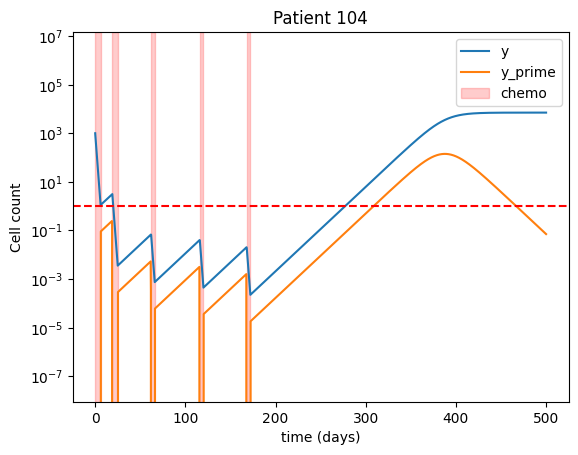

In [192]:
#plot the original trajectory and its derivative
fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results, label='y')
plt.plot(t, results_prime, label='y_prime')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()

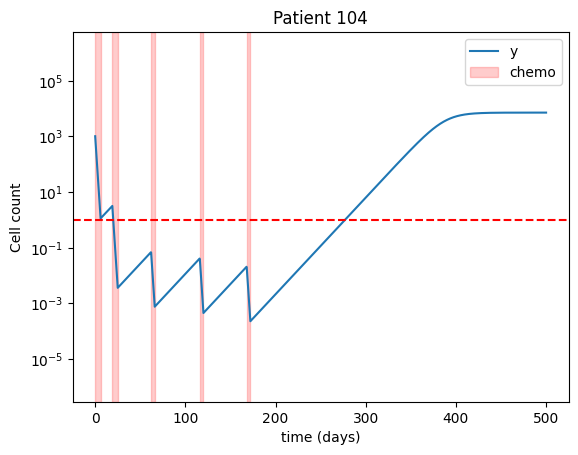

In [193]:
# plot a simple simulation
#original trajectory on its own

fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results, label='y')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()


In [194]:
#using SINDy for one trajectory of hoffman

control_values=[]
num_rows,num_col=results.shape
print(num_rows)

for time in t:
      control_values.append(treatment_function(time,cycles)) #get the control values for each time point
#print(results.shape)

results=np.array(results)
control_values=np.array(control_values)




#goal is to solve X'=Theta(X)*Xi for Xi


#data=results_smooth
#data_c=np.c_[results_smooth,control_values] #adds control_values as a second column

#print(control_values.shape)
#print(data_c.shape)

data=results
data_c=np.c_[results,control_values] #adds control_values as a second column

print(control_values.shape)
print(data_c.shape)

#Derivatives X'
data_prime=results_prime_true #take data_prime to be the true derivative

#fd=FiniteDifference()
#data_prime=fd._differentiate(data,t) #derivative does not include c, X'
#print("The size of X' is ", data_prime.shape)



#Libraries (Theta(X))
theta_lib_c=PolynomialLibrary(degree=2) #restrict to polynomials of deg 2
functions = [lambda x : x, lambda x : x*x, lambda x ,y : x*y]
customlib=CustomLibrary(library_functions=functions)

customlib.fit(data_c) #fit to our data
print(customlib.get_feature_names())
theta_c=customlib.transform(data_c) #transform to the correct size (,5)
print("The size of theta_c is", theta_c.shape)

#solve X'=Theta(X)*Xi for Xi
#use least squares solution as initial guess
Xi=np.linalg.lstsq(theta_c,data_prime)[0] #Is our initial guess using Python's least squares solver
print("Xi is ", Xi)

Xi_row,Xi_col=Xi.shape
print(Xi_row)
print(Xi_col)



Lambda=0.000000000001 #Sparsification knob (this was the value given in the PNAS paper for Lorenz)
            #This loop is adapted from the Sindy_PNAS paper, SI Appendix and converted into Python
for k in range(1000):
  smallinds=(np.absolute(Xi)<Lambda) #find all "very small" coefficients
               #print(smallinds)
  Xi[smallinds]=0 #set them=0
            #print(Eps_P)
  for ind in range(Xi_col): #Xi_col is the number of state variables
     biginds=np.logical_not(smallinds[:,ind]) #regress dynamics onto remaining terms
     Xi[biginds,ind]=np.linalg.lstsq(theta_c[:,biginds],data_prime[:,ind])[0]
print(Xi)

print(Xi.shape)

#print(results)

2000
(2000,)
(2000, 2)
['f0(x0)', 'f0(x1)', 'f1(x0)', 'f1(x1)', 'f2(x0,x1)']
The size of theta_c is (2000, 5)
Xi is  [[ 8.00447367e-02]
 [ 2.54279291e-18]
 [-1.13378070e-05]
 [-1.30785257e-14]
 [-1.21140130e+00]]
5
1
[[ 8.00447367e-02]
 [ 0.00000000e+00]
 [-1.13378070e-05]
 [ 0.00000000e+00]
 [-1.21140130e+00]]
(5, 1)


<__array_function__ internals>:180: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


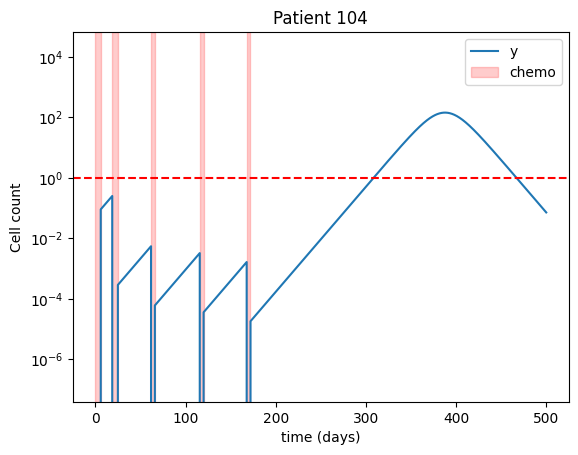

In [195]:
# plot a simple simulation

fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, data_prime, label='y')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()

In [196]:
print(theta_c)

[[1.00000000e+03 1.00000000e+00 1.00000000e+06 1.00000000e+00
  1.00000000e+03]
 [7.51677783e+02 1.00000000e+00 5.65019489e+05 1.00000000e+00
  7.51677783e+02]
 [5.65365411e+02 1.00000000e+00 3.19638048e+05 1.00000000e+00
  5.65365411e+02]
 ...
 [7.05906279e+03 0.00000000e+00 4.98303674e+07 0.00000000e+00
  0.00000000e+00]
 [7.05908104e+03 0.00000000e+00 4.98306252e+07 0.00000000e+00
  0.00000000e+00]
 [7.05909894e+03 0.00000000e+00 4.98308779e+07 0.00000000e+00
  0.00000000e+00]]


In [197]:
def recovered_model(y, t, params, treatment_function, cycles):
    """
    Differential equation for model recovered by SINDy

    Args:
        y (float): Current population size.
        t (float): Current time.
        params (array float): array with parameter values.


    Returns:
        float: The rate of change of the population size (dy/dt).
    """
    control = treatment_function(t,cycles)
    a0,a1,a2,a3,a4=params
    dydt = a0*y+a1*control+a2*y*y+a3*control*control+a4*y*control

    return dydt

In [198]:
a0=Xi[0]
a1=Xi[1]
a2=Xi[2]
a3=Xi[3]
a4=Xi[4]
params=[a0,a1,a2,a3,a4]
results_hat = odeint(recovered_model, La_o , t, args=(params,treatment_function,cycles))
print(results[40],results_hat[40])
print(results[-1],results_hat[-1])
print(t.shape)

MSE = np.square(np.subtract(results[:,0],results_hat[:,0])).mean()
print(MSE)

[1.53752672] [1.53752665]
[7059.0989422] [7059.09897153]
(2000,)
0.0002287319559281969


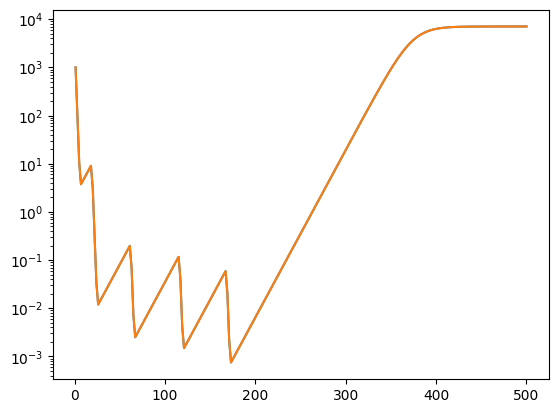

In [51]:
# plot a simple simulation
fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results, label='y')
plt.plot(t, results_hat, label='y_hat')
plt.yscale('log')

In [ ]:
# #This is used to solve WITHOUT treatment
# # determine treatment cycles
# cycles = [ [],[] ] # we provide empty treatment cycles

# # names of the parameters to fit
# params = [p_l, K_A, d_k, c]
# ## This is how we read the treatment data for a patient

# results = odeint(logistic_growth_controlled, La_o , t, args=(params, treatment_function, cycles))

In [ ]:
# #Used to recover model WITHOUT treatment
# #using SINDy for one trajectory of hoffman

# control_values=[]
# num_rows,num_col=results.shape
# print(num_rows)

# for time in t:
#       control_values.append(treatment_function(time,cycles)) #get the control values for each time point
# print(results.shape)

# results=np.array(results)
# control_values=np.array(control_values)




# #goal is to solve X'=Theta(X)*Xi for Xi

# #Data matrices (X) (one includes c, once does not)
# #data_c=np.stack((results, control_values), axis=-1) # data includes control
# data=results
# data_c=np.c_[results,control_values] #adds control_values as a second column

# print(control_values.shape)
# print(data_c.shape)

# #Derivatives X'
# fd=FiniteDifference()
# data_prime=fd._differentiate(results,t) #derivative does not include c, X'
# print("The size of X' is ", data_prime.shape)



# #Libraries (Theta(X))
# theta_lib_c=PolynomialLibrary(degree=2) #restrict to polynomials of deg 2
# functions = [lambda x : x, lambda x : x*x, lambda x ,y : x*y]
# customlib=CustomLibrary(library_functions=functions)

# customlib.fit(data_c) #fit to our data
# print(customlib.get_feature_names())
# theta_c=customlib.transform(data_c) #transform to the correct size (,5)
# print("The size of theta_c is", theta_c.shape)

# #solve X'=Theta(X)*Xi for Xi
# #use least squares solution as initial guess
# Xi=np.linalg.lstsq(theta_c,data_prime)[0] #Is our initial guess using Python's least squares solver
# print("Xi is ", Xi)

# Xi_row,Xi_col=Xi.shape
# print(Xi_row)
# print(Xi_col)



# Lambda=0.000000000001 #Sparsification knob (this was the value given in the PNAS paper for Lorenz)
#             #This loop is adapted from the Sindy_PNAS paper, SI Appendix and converted into Python
# for k in range(1000):
#   smallinds=(np.absolute(Xi)<Lambda) #find all "very small" coefficients
#                #print(smallinds)
#   Xi[smallinds]=0 #set them=0
#             #print(Eps_P)
#   for ind in range(Xi_col): #5 is the number of state variables
#      biginds=np.logical_not(smallinds[:,ind]) #regress dynamics onto remaining terms
#      Xi[biginds,ind]=np.linalg.lstsq(theta_c[:,biginds],data_prime[:,ind])[0]
# print(Xi)

# print(Xi.shape)

# #print(results)

9801
(9801, 1)
(9801,)
(9801, 2)
The size of X' is  (9801, 1)
['f0(x0)', 'f0(x1)', 'f1(x0)', 'f1(x1)', 'f2(x0,x1)']
The size of theta_c is (9801, 5)
Xi is  [[ 8.00446713e-02]
 [ 0.00000000e+00]
 [-1.13377976e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
5
1
[[ 8.00446713e-02]
 [ 0.00000000e+00]
 [-1.13377976e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
(5, 1)


In [ ]:
#Used to recover model WITHOUT Treatment
# a0=Xi[0]
# a1=Xi[1]
# a2=Xi[2]
# a3=Xi[3]
# a4=Xi[4]
# params=[a0,a1,a2,a3,a4]
# results_hat = odeint(recovered_model, La_o , t, args=(params,treatment_function,cycles))
# print(results_hat)
# MSE = np.square(np.subtract(results[:,0],results_hat[:,0])).mean()
# print(MSE)

[[1000.        ]
 [1003.44027682]
 [1006.89042152]
 ...
 [7059.98411999]
 [7059.98411999]
 [7059.98411999]]
5.898115239194044e-07


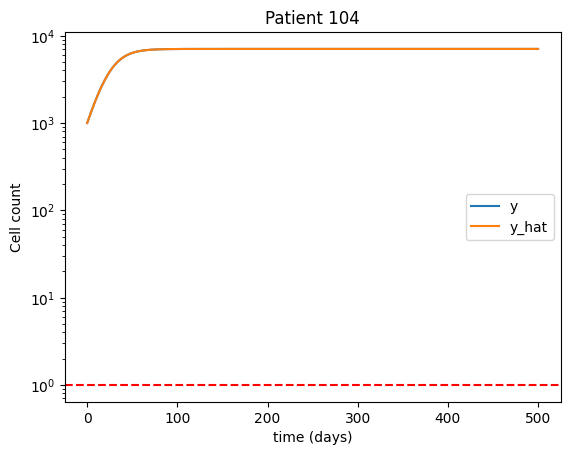

In [ ]:
# # plot a simple simulation
# fig, ax = plt.subplots()
# chemo_start_times, chemo_end_times = cycles
# plt.plot(t, results, label='y')
# plt.plot(t, results_hat, label='y_hat')
# plt.yscale('log')

# for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
#     label = None
#     # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
#     if i == 0:
#         label = 'chemo'
#     plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
#                         label=label, transform=ax.get_xaxis_transform())
# ### Added This Part ###
# plt.axhline(y = 1, color = 'r', linestyle = '--')
# plt.title(f'Patient {patient_id}')
# plt.xlabel('time (days)')
# plt.ylabel('Cell count')
# plt.legend()
# plt.show()

In [ ]:

# split the time points up into intervals where treatment is exclusively on or exclusively off
# split the time points at the discontinuities
# take the derivative of each interval separately
# concatenate derivatives into one vector

# Setting parameters for simulations
p_l = 0.11337807
K_A = 10000
d_k = 1/30
c = 1.2114013

# Initial value
La_o = 10000*.10
t = np.linspace(0, 500, 1001) # Time points

patient_id = 104
cycles = treatment_cycle( patient_id )

# names of the parameters to fit
params = [p_l, K_A, d_k, c]

discont=np.array([0,6,19,25,62,66,116,120,168,172,t[-1]]) #points where treatment turns on and off; discontinuities
epsilon=0

#split up time into sub-intervals where treatment exclusively on or exclusively off
split_time=[] #split time is a list of intervals of time point. Each entry is an array containing time points
for i in range(discont.shape[0]-1):
  t1=t[(t> discont[i]) & (t<discont[i+1])] #split at the discontinuities; obtain a sub-interval
  #print(t1)
  split_time.append(t1)

for point in discont:
  t = t[(t < point-epsilon) | (t > point+epsilon)] #remove the discontinuities from the original t
print(t)


results = odeint(logistic_growth_controlled, La_o , t, args=(params, treatment_function, cycles)) #y-values
results_prime_true=np.array([logistic_growth_controlled(y,time,params,treatment_function,cycles) for y,time in zip(results,t)])
#true derivative; found by evaluating the ODE at each time point and its corresponding y-value
print(results_prime_true.shape)



count=0

results_prime_est=[] #create an empty list to contain the derivative values
for time in split_time: # loop through each time interval ([0,6], [6,19], etc)
  results_i=results[count:count+time.shape[0]] #take the y-values corresponding to each time interval
  count+=time.shape[0]
  fd=FiniteDifference()
  results_prime_i=fd._differentiate(results_i,time) #Compute the derivatives for each interval separately
  results_prime_est=np.append(results_prime_est,results_prime_i) #, add to the list of derivative values

results_prime_est=np.c_[results_prime_est] #resize array
print(results_prime_est.shape)

[  0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.5
   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.   12.5
  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.   18.5
  19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.   24.5  25.5
  26.   26.5  27.   27.5  28.   28.5  29.   29.5  30.   30.5  31.   31.5
  32.   32.5  33.   33.5  34.   34.5  35.   35.5  36.   36.5  37.   37.5
  38.   38.5  39.   39.5  40.   40.5  41.   41.5  42.   42.5  43.   43.5
  44.   44.5  45.   45.5  46.   46.5  47.   47.5  48.   48.5  49.   49.5
  50.   50.5  51.   51.5  52.   52.5  53.   53.5  54.   54.5  55.   55.5
  56.   56.5  57.   57.5  58.   58.5  59.   59.5  60.   60.5  61.   61.5
  62.5  63.   63.5  64.   64.5  65.   65.5  66.5  67.   67.5  68.   68.5
  69.   69.5  70.   70.5  71.   71.5  72.   72.5  73.   73.5  74.   74.5
  75.   75.5  76.   76.5  77.   77.5  78.   78.5  79.   79.5  80.   80.5
  81.   81.5  82.   82.5  83.   83.5  84.   84.5  8

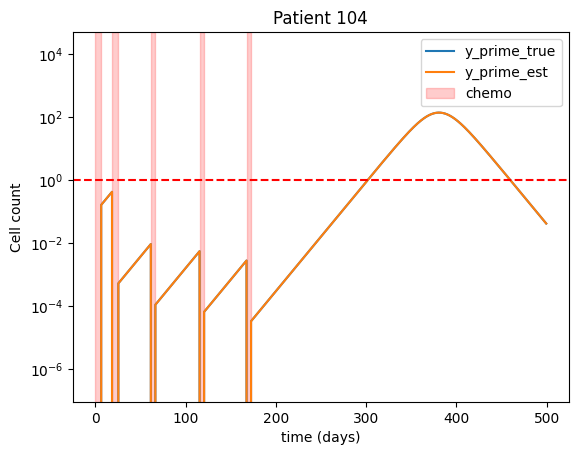

The MSE of the derivatives is 9.109576715616269


In [ ]:
#plot the true derivatives (ODE evaluated at y and t) vs the PySindy derivative
fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results_prime_true, label='y_prime_true')
plt.plot(t, results_prime_est, label='y_prime_est')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()
MSE_der = np.square(np.subtract(results_prime_true[:,0],results_prime_est[:,0])).mean()
print("The MSE of the derivatives is", MSE_der)

In [ ]:
#using SINDy for one trajectory of hoffman

control_values=[]
num_rows,num_col=results.shape
print(num_rows)

for time in t:
      control_values.append(treatment_function(time,cycles)) #get the control values for each time point
print(results.shape)

results=np.array(results)
control_values=np.array(control_values)

#goal is to solve X'=Theta(X)*Xi for Xi

data=results
data_c=np.c_[results,control_values] #adds control_values as a second column

print(control_values.shape)
print(data_c.shape)

#Derivatives X'
data_prime=results_prime_est #derivatives for each time interval were computed separately
print("The size of X' is ", data_prime.shape)



#Libraries (Theta(X))
theta_lib_c=PolynomialLibrary(degree=2) #restrict to polynomials of deg 2
functions = [lambda x : x, lambda x : x*x, lambda x ,y : x*y]
customlib=CustomLibrary(library_functions=functions)

customlib.fit(data_c) #fit to our data
print(customlib.get_feature_names())
theta_c=customlib.transform(data_c) #transform to the correct size (,5)
print("The size of theta_c is", theta_c.shape)

#solve X'=Theta(X)*Xi for Xi
#use least squares solution as initial guess
Xi=np.linalg.lstsq(theta_c,data_prime)[0] #Is our initial guess using Python's least squares solver
print("Xi is ", Xi)

Xi_row,Xi_col=Xi.shape
print(Xi_row)
print(Xi_col)



Lambda=0.000000000001 #Sparsification knob (this was the value given in the PNAS paper for Lorenz)
            #This loop is adapted from the Sindy_PNAS paper, SI Appendix and converted into Python
for k in range(1000):
  smallinds=(np.absolute(Xi)<Lambda) #find all "very small" coefficients
               #print(smallinds)
  Xi[smallinds]=0 #set them=0
            #print(Eps_P)
  for ind in range(Xi_col): #Xi_col is the number of state variables
     biginds=np.logical_not(smallinds[:,ind]) #regress dynamics onto remaining terms
     Xi[biginds,ind]=np.linalg.lstsq(theta_c[:,biginds],data_prime[:,ind])[0]
print(Xi)

print(Xi.shape)

#print(results)


990
(990, 1)
(990,)
(990, 2)
The size of X' is  (990, 1)
['f0(x0)', 'f0(x1)', 'f1(x0)', 'f1(x1)', 'f2(x0,x1)']
The size of theta_c is (990, 5)
Xi is  [[ 8.00210324e-02]
 [-1.04427165e+00]
 [-1.13342404e-05]
 [-1.04427165e+00]
 [-1.17107307e+00]]
5
1
[[ 8.00210324e-02]
 [-1.04427165e+00]
 [-1.13342404e-05]
 [-1.04427165e+00]
 [-1.17107307e+00]]
(5, 1)


In [ ]:
a0=Xi[0]
a1=Xi[1]
a2=Xi[2]
a3=Xi[3]
a4=Xi[4]
params=[a0,a1,a2,a3,a4]
results_hat = odeint(recovered_model, La_o , t, args=(params,treatment_function,cycles))
print(results)
print(results_hat)
MSE = np.square(np.subtract(results[:,0],results_hat[:,0])).mean()
print(MSE)

[[1.00000000e+03]
 [5.65526332e+02]
 [3.20420159e+02]
 [1.81738444e+02]
 [1.03141691e+02]
 [5.85557284e+01]
 [3.32497460e+01]
 [1.88822981e+01]
 [1.07237919e+01]
 [6.09056031e+00]
 [3.45919328e+00]
 [2.04490884e+00]
 [2.12838559e+00]
 [2.21526893e+00]
 [2.30569781e+00]
 [2.39981680e+00]
 [2.49777639e+00]
 [2.59973317e+00]
 [2.70585014e+00]
 [2.81629690e+00]
 [2.93124997e+00]
 [3.05089307e+00]
 [3.17541738e+00]
 [3.30502185e+00]
 [3.43991354e+00]
 [3.58030794e+00]
 [3.72642927e+00]
 [3.87851090e+00]
 [4.03679568e+00]
 [4.20153632e+00]
 [4.37299583e+00]
 [4.55144786e+00]
 [4.73717724e+00]
 [4.93048031e+00]
 [5.13166548e+00]
 [5.34105367e+00]
 [3.15728393e+00]
 [1.79323310e+00]
 [1.01850323e+00]
 [5.78481567e-01]
 [3.28562118e-01]
 [1.86614729e-01]
 [1.05992375e-01]
 [6.02009695e-02]
 [3.41926245e-02]
 [1.94205466e-02]
 [1.10303803e-02]
 [6.52076086e-03]
 [6.78702973e-03]
 [7.06417154e-03]
 [7.35263025e-03]
 [7.65286771e-03]
 [7.96536499e-03]
 [8.29062278e-03]
 [8.62916212e-03]
 [8.981525

<ipython-input-26-be7926615eb5>:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  results_hat = odeint(recovered_model, La_o , t, args=(params,treatment_function,cycles))


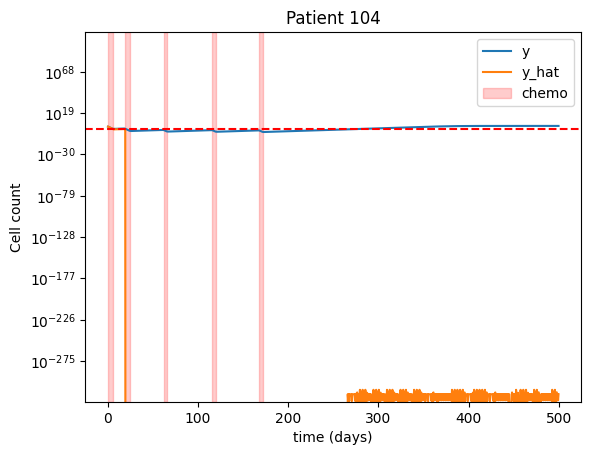

In [ ]:
# plot a simple simulation

fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results, label='y')
plt.plot(t, results_hat, label='y_hat')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()

(990,)


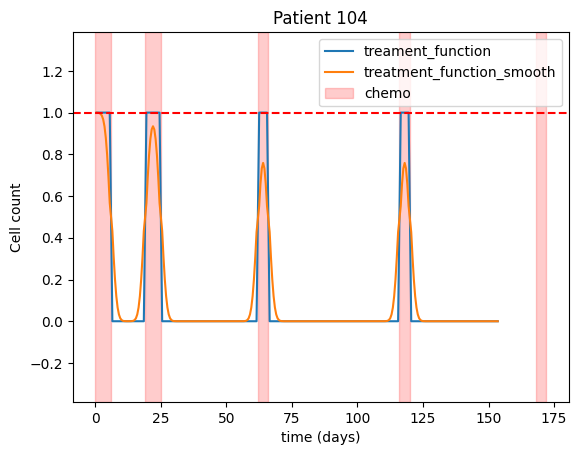

The MSE of the derivatives is 9.109576715616269


In [ ]:
treatment_function_values=np.array([treatment_function(time,cycles) for time in t])
print(treatment_function_values.shape)
values_smooth = gaussian_filter1d(treatment_function_values, sigma=3)
#print(treatment_function_values)
#print(values_smooth)
#plot the true derivative vs the PySindy derivative
fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t[0:300], treatment_function_values[0:300], label='treament_function')
plt.plot(t[0:300], values_smooth[0:300], label='treatment_function_smooth')
plt.yscale('linear')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()
#MSE_der = np.square(np.subtract(results_prime_true[:,0],results_prime[:,0])).mean()
print("The MSE of the derivatives is", MSE_der)

